# Using bucketers

!!! Note "Background knowledge"

    You might want to read up on some [scorecard development concepts](../discussion/scorecard_concepts.md) first.

An important part of developing a scorecard is the bucketing continous values into a set of of discrete buckets.

## Dummy dataset

Let's start first with a dummy dataset based on the [UCI credit card](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) dataset.

In [2]:
from skorecard.datasets import load_uci_credit_card

X, y = load_uci_credit_card(return_X_y=True)
X.head(4)

,EDUCATION,MARRIAGE,LIMIT_BAL,BILL_AMT1
0,1,2,400000.0,201800.0
1,2,2,80000.0,80610.0
2,1,2,500000.0,499452.0
3,1,1,140000.0,450.0


## A basic bucketer

`skorecard` offers a [set of bucketers](../api/bucketers/OptimalBucketer.md) that have a scikit-learn compatible interface. By default they will bucket all variables into `n_bins` buckets.

Some bucketers like [OptimalBucketer](../api/bucketers/OptimalBucketer.md) and [DecisionTreeBucketer](../api/bucketers/DecisionTreeBucketer.md) are supervised and can use information from `y` to find good buckets. You can control the numbers of buckets using `max_n_bins` instead of `n_bins`. 

In [3]:
from skorecard.bucketers import DecisionTreeBucketer

bucketer = DecisionTreeBucketer(max_n_bins=10)
X_transformed = bucketer.fit_transform(X, y)
X_transformed.head(4)

,EDUCATION,MARRIAGE,LIMIT_BAL,BILL_AMT1
0,0,1,9,9
1,1,1,3,7
2,0,1,9,9
3,0,0,5,0


In [4]:
X_transformed['BILL_AMT1'].value_counts().sort_index()

0    1343
1     404
2     574
3     462
4     400
5     359
6     857
7     789
8     500
9     312
Name: BILL_AMT1, dtype: int64

## Bucketing specific variables

Instead of applying a bucketer on all features, you'll likely want to apply it only to specific features. You can use the `variables` parameter for that:

In [5]:
bucketer = DecisionTreeBucketer(max_n_bins=10, variables=["BILL_AMT1"])
bucketer.fit_transform(X, y).head(4)

,EDUCATION,MARRIAGE,LIMIT_BAL,BILL_AMT1
0,1,2,400000.0,9
1,2,2,80000.0,7
2,1,2,500000.0,9
3,1,1,140000.0,0


## Inspecting bucketing results

`skorecard` bucketers have some methods to help you inspect the result of the bucketing process:

In [9]:
from skorecard.bucketers import EqualWidthBucketer
bucketer = EqualWidthBucketer(n_bins=5, variables=["BILL_AMT1"])
bucketer.fit(X, y)
bucketer.bucket_table('BILL_AMT1')


,bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV
0,0,"(-inf, -10319.399999999994]",3.0,0.000500,3.0,0.0,0.000000,-4.18,0.0
1,1,"(-10319.399999999994, 144941.2]",5408.0,0.901333,4188.0,1220.0,0.225592,0.01,0.0
2,2,"(144941.2, 300201.80000000005]",490.0,0.081667,395.0,95.0,0.193878,-0.18,0.0
3,3,"(300201.80000000005, 455462.4]",75.0,0.012500,55.0,20.0,0.266667,0.23,0.0
4,4,"(455462.4, inf)",24.0,0.004000,14.0,10.0,0.416667,0.90,0.0
5,5,Missing,0.0,0.000000,0.0,0.0,NaN,0.00,0.0


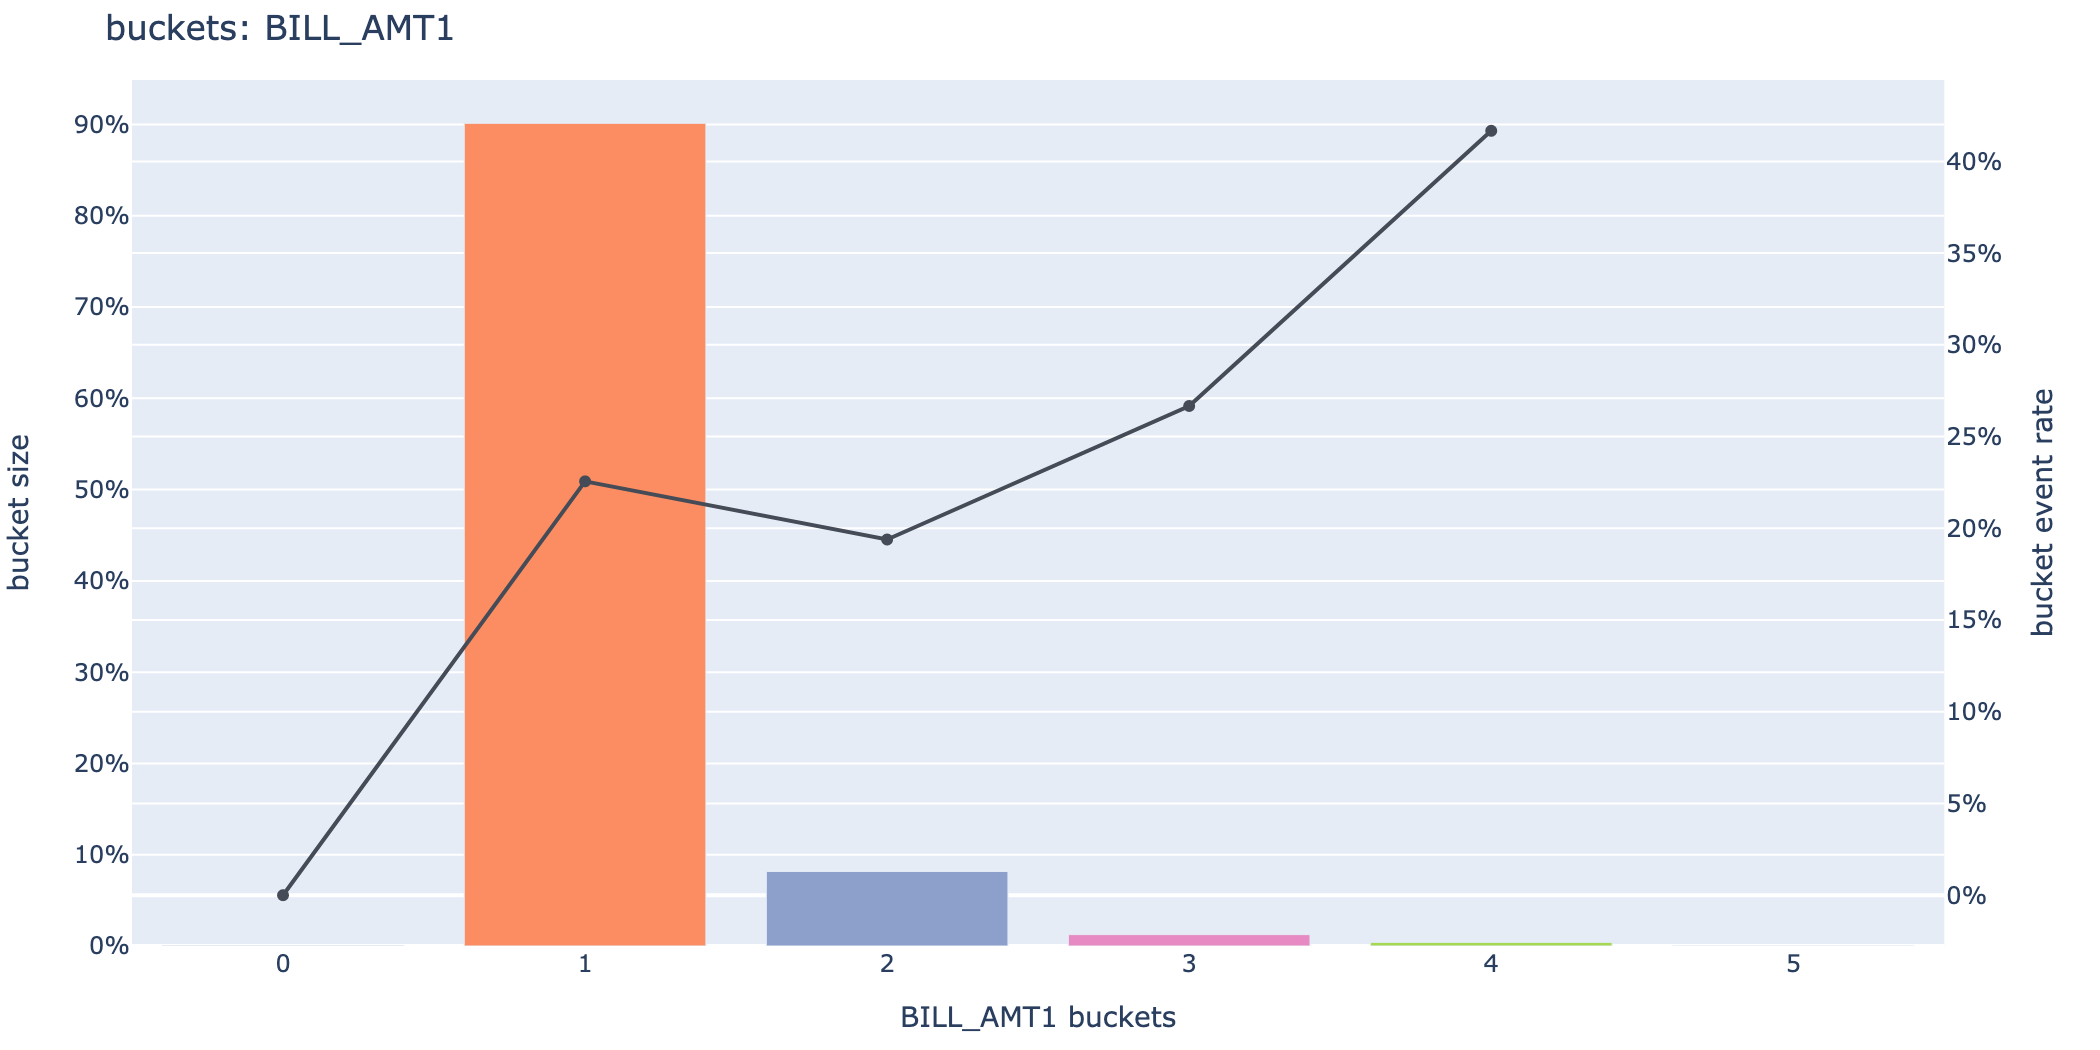

In [11]:
bucketer.plot_bucket('BILL_AMT1', format="png", scale=2, width=1050, height=525) # remove format argument for an interactive plotly plot.

## scikit-learn pipelines 

`skorecard` bucketers play nicely with scikit-learn, so to use different bucketers on different features you can use a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

In [5]:
from sklearn.pipeline import make_pipeline
from skorecard.bucketers import EqualFrequencyBucketer

pipe = make_pipeline(
    EqualFrequencyBucketer(n_bins=10, variables=["BILL_AMT1"]),
    DecisionTreeBucketer(max_n_bins=5, variables=["LIMIT_BAL"])
)
pipe.fit_transform(X, y).head(4)

,EDUCATION,MARRIAGE,LIMIT_BAL,BILL_AMT1
0,1,2,4,9
1,2,2,2,7
2,1,2,4,9
3,1,1,3,1


## Dealing with missing values

`scorecard` bucketers offer native support for missing values but will put them in a separate bucket by default. 

In the example below, can you can see that the single missing value is put into a new bucket '2'.

In [6]:
import numpy as np
import pandas as pd
df = pd.DataFrame({'counts': [1,2,2,1,4,2,np.nan,1,3]})
EqualFrequencyBucketer(n_bins=2).fit_transform(df).value_counts()

counts
0         6
1         2
2         1
dtype: int64

## Dealing with special values

You might have some features with values that you need to have in a separate bucket. You can define a dictionary with the buckets you want, and pass them to the bucketer:

In [13]:
from skorecard.bucketers import EqualWidthBucketer

specials = {
    "LIMIT_BAL": {"=50000": [50000], "in [20001,30000]": [20000, 30000]},
    "EDUCATION": {"=High School, Graduate School": [1,3]}
}

cols = ['LIMIT_BAL','EDUCATION']
X_transformed = EqualWidthBucketer(n_bins=3, specials=specials, variables=cols).fit_transform(X, y)
X_transformed['EDUCATION'].value_counts()


4    3199
0    2726
2      62
1      13
Name: EDUCATION, dtype: int64

## Dealing with categoricals

`scorecard` bucketers assume features are numerical. Some bucketers supports categorical features as well ([OptimalBucketer](../api/bucketers/OptimalBucketer.md) and [OrdinalCategoricalBucketer](../api/bucketers/OrdinalCategoricalBucketer.md)). If you have a categorical feature, you can bucket them directly:

In [9]:
from skorecard.bucketers import OptimalBucketer
import random

# Add a categorical feature
pets = ["no pets"] * 3000 + ["cat lover"] * 1500 + ["dog lover"] * 1000 + ["rabbit"] * 498 + ["gold fish"] * 2
random.Random(42).shuffle(pets)
X["pet_ownership"] = pets

bucketer = OptimalBucketer(max_n_bins=3, variables=["pet_ownership"], variables_type="categorical", cat_cutoff=None)
bucketer.fit_transform(X, y)['pet_ownership'].value_counts().sort_index()

0    1998
1    3000
2    1002
Name: pet_ownership, dtype: int64

??? note
    If interested into digging into the internals of the buckets, you can access the fitted attribute
    `features_bucket_mapping_`. For example:

    ```python
    bucketer.features_bucket_mapping_.get('pet_ownership').labels
    # {0: 'cat lover, rabbit',
    # 1: 'no pets',
    # 2: 'dog lover',
    # 3: 'gold fish',
    # 4: 'other',
    # 5: 'Missing'}
    ```


## Up next

The bucketers are useful when you want to do same basic bucketing, but in practice using a `BucketingProcess` is much more usefull.
